In [ ]:
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [1]:
if(!requireNamespace("BiocManager", quietly = TRUE)) {
 install.packages("BiocManager")
}
BiocManager::install("msqrob2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'BiocVersion', 'msqrob2'

also installing the dependencies ‘formatR’, ‘zlibbioc’, ‘bitops’, ‘clue’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘MultiAssayExperiment’, ‘S4Vectors’, ‘IRanges’, ‘BiocGenerics’, ‘ProtGenerics’, ‘AnnotationFilter’, ‘lazyeval’, ‘Biobase’, ‘MsCoreUtils’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘futile.logger’, ‘snow’, ‘MatrixGenerics’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘DelayedArray’, ‘QFeatures’, ‘lme4’, ‘BiocParallel’, ‘limma’, ‘SummarizedExperiment’


Old packages: 'blob', 'broom', 'cli', 'credentials', 'googledrive',
  'googlesheets4', 'haven', 'openssl', 'pillar', 'readr', 'reprex',
  'rmark

## MS-based workflow

sample -> proteins -> peptides -> HPLC (separate peptides) -> ESI -> ion trap (ionise peptides w/ charge) -> MS (Quantification, peaks analysis) or MS2 (Identification, one peptide species: high energy, match observed spectrum w/ database)


Peptide characteristics
- Modification

- Ionisation Efficiency: huge variability

- Identification


> 1) Misidentification -> outliers

> 2) MS2 selection on peptide abundance

> 3) context dependent missingness

> 4) Non-random missingness

Unbalanced peptide identifications across samples and messy data

**1.2 Level of Quantification**
- MS-based proteomics returns peptides: pieces of proteins

- Quantification commonly required on the proten level

**1.3 Label-free Quantitiave proteomics** 
peptides intensities -> preprocessing -> stats analysis

- Pre-processing -> normalization, summarization, imputation

- Stats analysis -> differentially abundant proteins

**1.4 CPTAC Spike-in study**
 - same trypsin-digested yeast proteome background in each sample

 - trypsin-digested Sigma UPS1 standard: 48 different human proteins spiked in at 5 different concentrations (treatment A-E)

 - samples repeatedly run on diff instruments in diff labs

 - after MaxQuant search w/ match between runs option
 
 a) 41% of all proteins are quantified in all samples

 b) 6.6% of all peptides are quantified in all samples




In [71]:
install.packages("plotly")
library(tidyverse)
library(limma)
library(QFeatures)
library(msqrob2)
library(plotly)
library(ggplot2)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Import the data in R

In [4]:
# Use the peptides.txt file from MS-data quantified w/ maxquant that contains MS1 intensities summarized at the peptide level
peptidesFile <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/fullCptacDatasSetNotForTutorial/peptides.txt"

# maxquant stores the intensity data for the different samples in columns that start w/ intensity.
# can retrieve the column names w/ the intensity data w/ the code below
ecols <- grep("Intensity\\.", names(read.delim(peptidesFile)))

# Read the data and store it in QFeatures object

pe <- readQFeatures(
  table = peptidesFile, 
  fnames = 1,
  ecol = ecols,
  name = 'peptideRaw', sep = '\t'
)

In [ ]:
# Explore the object, rowData contains info on the features (peptides) in the assay e.g. Sequence, protein, ...
rowData(pe[['peptideRaw']])

In [6]:
# colData contains information on the samples
colData(pe)
# no info is stored yet on the design

DataFrame with 45 rows and 0 columns

In [7]:
pe %>% colnames

CharacterList of length 1
[["peptideRaw"]] Intensity.6A_1 Intensity.6A_2 ... Intensity.6E_9

- sample name include the spike-in condition

- also end in number, 1-3 is from lab 1; 4-6 from lab 2; 7-9 from lab 3

In [8]:
colData(pe)$lab <- rep(rep(paste0('lab', 1:3), each=3), 5) %>%
  as.factor

colData(pe)$condition <- pe[['peptideRaw']] %>%
  colnames %>%
  substr(12, 12) %>%
  as.factor

colData(pe)$spikeConcentration <- rep(c(A = 0.25, B = 0.74, C = 2.22, D = 6.67, E = 20),
                                      each = 9)


In [9]:
colData(pe)

DataFrame with 45 rows and 3 columns
                    lab condition spikeConcentration
               <factor>  <factor>          <numeric>
Intensity.6A_1     lab1         A               0.25
Intensity.6A_2     lab1         A               0.25
Intensity.6A_3     lab1         A               0.25
Intensity.6A_4     lab2         A               0.25
Intensity.6A_5     lab2         A               0.25
...                 ...       ...                ...
Intensity.6E_5     lab2         E                 20
Intensity.6E_6     lab2         E                 20
Intensity.6E_7     lab3         E                 20
Intensity.6E_8     lab3         E                 20
Intensity.6E_9     lab3         E                 20

## Preprocessing
1. Log-transformation

Peptide AALEELVK from spiked-in UPS protein P12081. Only show data from lab1

In [11]:
peptide <- 'AALEELVK'
subset <- pe[peptide, colData(pe)$lab=='lab1']

plotWhyLog <- data.frame(concentration = colData(subset)$spikeConcentration,
              y = assay(subset[['peptideRaw']]) %>% c
              ) %>%
      ggplot(aes(concentration, y)) +
      geom_point() +
      xlab('concentration (fmol/l)') +
      ylab('intensity') + 
      ggtitle(paste('peptide ', peptide, ' in lab1', sep='')) 

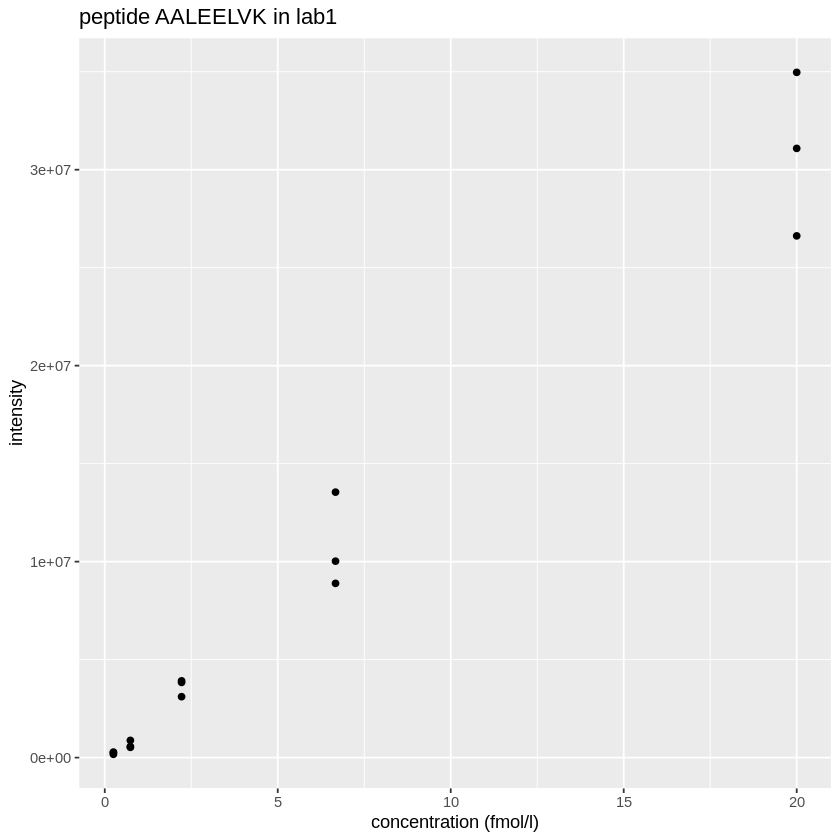

In [12]:
plotWhyLog

variance increases w/ the mean -> Multiplicative error structure

In [17]:
plotLog <- data.frame(concentration = colData(subset)$spikeConcentration, 
            y = assay(subset[["peptideRaw"]]) %>% c
            ) %>% 
            ggplot(aes(concentration, y)) +
            geom_point() +
            scale_x_continuous(trans='log2') + scale_y_continuous(trans='log2') +
            xlab("concentration (fmol/l)") +
            ggtitle("peptide AALEELVK in lab1 with axes on log scale")

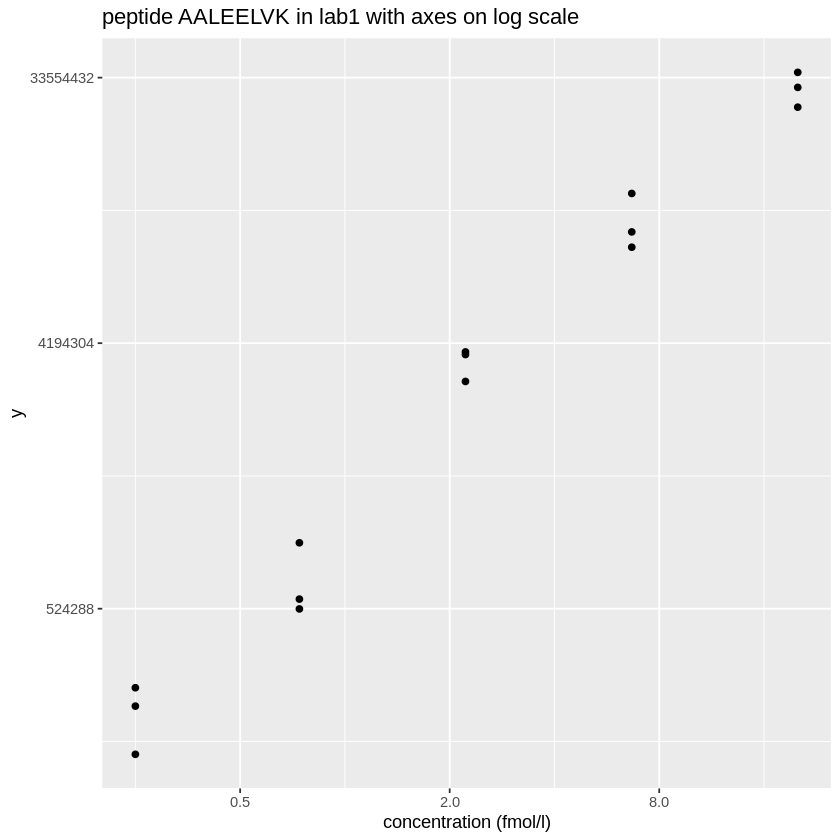

In [18]:
plotLog

- data seems to be homoscedastic on log-scale -> log transformation of the intensity data

In [19]:
# calculate how many non zero intensities we have for each peptide and this can be useful for filtering
rowData(pe[['peptideRaw']])$nNonZero <- rowSums(assay(pe[['peptideRaw']]) > 0)

# peptides w/ zero intensities are missing peptides and should be represent w/ a NA value rather than 0
pe <- zeroIsNA(pe, 'peptideRaw')

# log base 2 transform
pe <- logTransform(pe, base = 2, i = 'peptideRaw', name = 'peptideLog')

2. Filtering

Remove peptides that aren't informative:

- Reverse sequences

- Only identified by modification site (only modified peptides detected)

- razor peptides: non-unique peptides assigned to the protein group w/ the most other peptides

- contaminants

- peptides few identifications

- proteins that are only identified w/ one or a few peptides

In [20]:
# Handling overlapping protein groups
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Proteins %in%
                      smallestUniqueGroups(rowData(pe[['peptideLog']])$Proteins),]

In [21]:
# Remove reverse sequences(decoys) & contaminants
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Reverse != '+', ]
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Potential.contaminant != '+',]

In [22]:
# Drop peptides that were only identified in one sample
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$nNonZero >= 2, ]
nrow(pe[['peptideLog']])

[1] 10478

3. Normalization


In [24]:
densityConditionD <- pe[['peptideLog']][, colData(pe)$condition == 'D'] %>%
  assay %>%
  as.data.frame() %>%
  gather(sample, intensity) %>%
  mutate(lab = colData(pe)[sample, 'lab']) %>%
  ggplot(aes(x=intensity, group=sample, color=lab)) +
    geom_density() +
    ggtitle('condition D')

densityLab2 <- pe[['peptideLog']][, colData(pe)$lab == 'lab2'] %>%
  assay %>%
  as.data.frame() %>%
  gather(sample, intensity) %>%
  mutate(condition = colData(pe)[sample, 'condition']) %>%
  ggplot(aes(x=intensity, group=sample, color=condition)) +
    geom_density() + 
    ggtitle('lab2')

Warning message:
“Removed 39179 rows containing non-finite values (stat_density).”


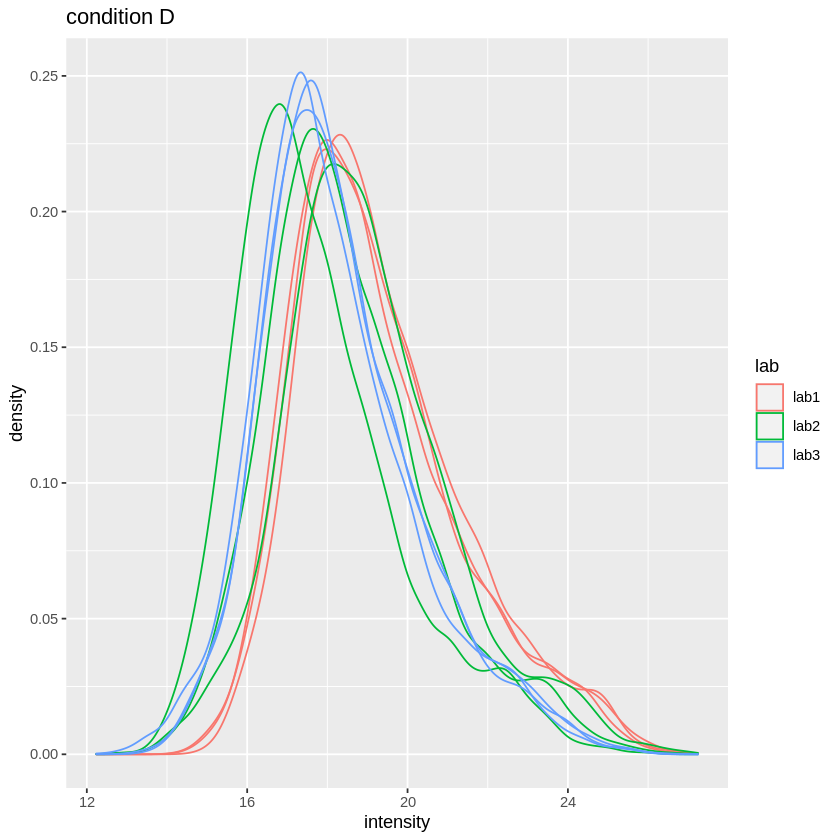

In [26]:
densityConditionD

Warning message:
“Removed 44480 rows containing non-finite values (stat_density).”


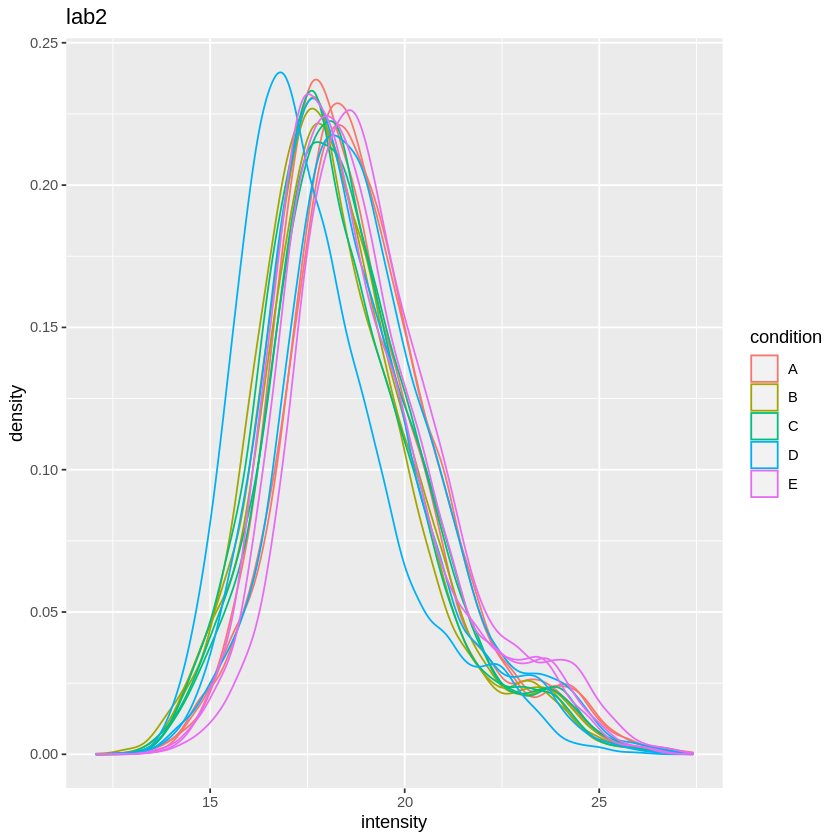

In [28]:
densityLab2

- even in very clean synthetic dataset (same background, only 48 UPS proteins can be different) the marginal peptide intensity distribution across samples can be quite distinct

1) Considerable effects between and within labs for replicate samples

2) Considerable effects between samples w/ diff spike-in concentration

--> normalization is needed

Mean or median?

- mean is very sensitive to outliers


In [29]:
# normalization by median centering

pe <- normalize(pe,
                i = 'peptideLog', 
                name = 'peptideNorm',
                method = 'center.median')

In [33]:
densityConditionDNorm <- pe[['peptideNorm']][, colData(pe)$condition=='D'] %>%
                assay %>%
                as.data.frame() %>%
                gather(sample, intensity) %>%
                mutate(lab = colData(pe)[sample, 'lab']) %>%
                ggplot(aes(x=intensity, group=sample, color=lab)) + 
                  geom_density() + 
                  ggtitle('condition D')

densityLab2Norm <- pe[['peptideNorm']][, colData(pe)$lab=='lab2'] %>%
                assay %>%
                as.data.frame() %>%
                gather(sample, intensity) %>%
                mutate(condition = colData(pe)[sample, 'condition']) %>%
                ggplot(aes(x=intensity, group=sample, color=condition)) + 
                  geom_density() + 
                  ggtitle('lab2')

Warning message:
“Removed 39179 rows containing non-finite values (stat_density).”


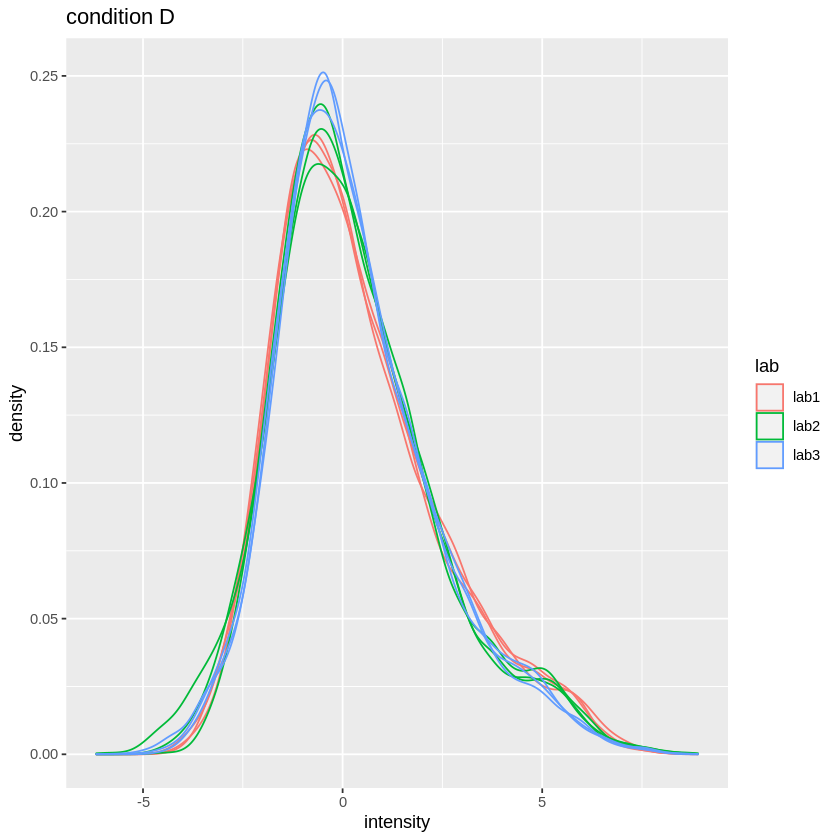

In [34]:
densityConditionDNorm

Warning message:
“Removed 44480 rows containing non-finite values (stat_density).”


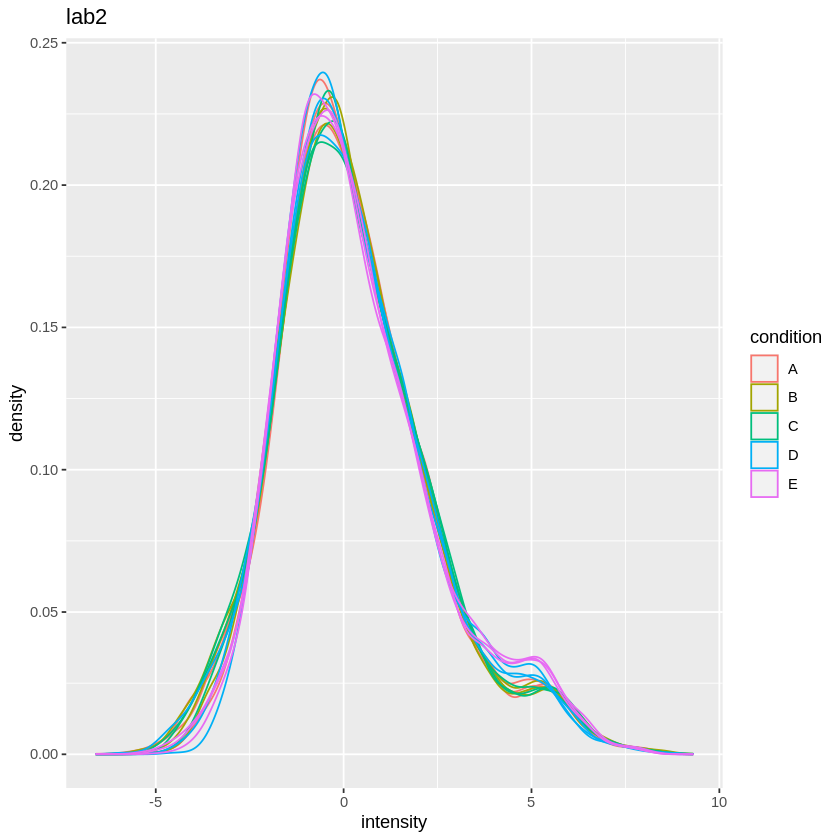

In [35]:
densityLab2Norm

- Upon normalization the marginal distributions of the peptide intensities across samples are much more comparable

- still see deviations: can be due to technical variability

- in micro-array literature, quantile normalization is used to force the median and all other quantiles to be equal across samples

- in proteomics quantiles normalization often introduces artifacts due to a difference in missing peptides across samples

- more advanced methods should be developed for normalizing proteomics data

- if there are differences in the width of the marginal distributions of the data across samples -> standardized/scaling by using a robust estimator for location and scale

4. Summarization

illustrate summarizatio issues using a subset of the cptac study (Lab 2, conditon A and E) for a spiked protein (UPS P12081)


In [39]:
summaryPlot <- function(pe, lab, conditions) {
      pe[['peptideNorm']][
                rowData(pe[['peptideNorm']])$Proteins == 'P12081ups|SYHC_HUMAN_UPS',
                colData(pe)$lab==lab&colData(pe)$condition %in% conditions] %>%
              assay %>%
              as.data.frame %>%
              rownames_to_column(var = 'peptide') %>%
              gather(sample, intensity, -peptide) %>%
              mutate(condition = colData(pe)[sample, 'condition']) %>%
              ggplot(aes(x = peptide, y = intensity, color = sample, group = sample, label = condition),
                    show.legend = F) +
                geom_line(show.legend = F) +
                geom_text(show.legend = F) + 
                theme_minimal() + 
                theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) + 
                xlab('Peptide') + 
                ylab('Intensity (log2)')
}                

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Warning message:
“Removed 90 rows containing missing values (geom_text).”


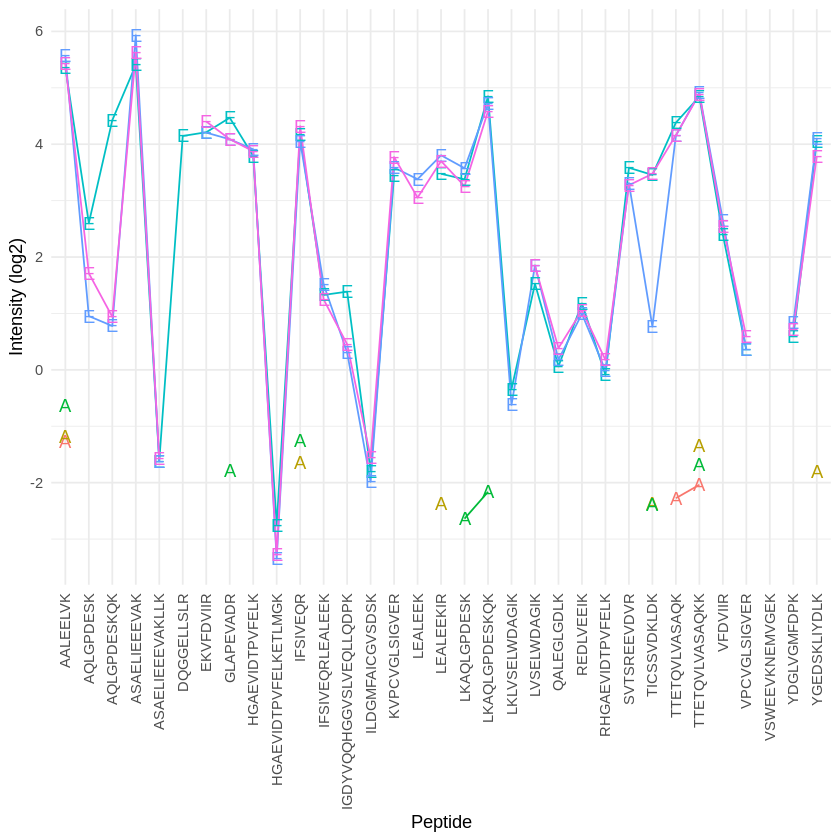

In [40]:
summaryPlot(pe, 'lab2', c('A', 'E'))

- intensities from multiple peptides for each sample in a sample

- strong peptide effect - Unbalanced peptide identification

- pseudo replication: peptide intensities from a particular protein in the same sample are correlatd, i.e. they more alike than peptide intensities from a particular protein between samples

--> summarize all peptide intensities from the same protein in a sample into a single protein expression value

normalization:

1) mean summarization: $y_{ip} = \beta_i^{samp} + \epsilon_{ip} $

2) median summarization

3) maxquant's maxLFQ summarization (in protein groups file)

4) model based summarization: $y_{ip} = \beta_i^{samp} + \beta_p^{pep} + \epsilon_{ip} $

## [Tutorial](https://statomics.github.io/PDA21/pda_tutorialPreprocessing.html)
Our first case-study is a subset of the data of the 6th study of the Clinical Proteomic Technology Assessment for Cancer (CPTAC). In this experiment, the authors spiked the Sigma Universal Protein Standard mixture 1 (UPS1) containing 48 different human proteins in a protein background of 60 ng/μL Saccharomyces cerevisiae strain BY4741 (MATa, leu2Δ0, met15Δ0, ura3Δ0, his3Δ1). Two different spike-in concentrations were used: 6A (0.25 fmol UPS1 proteins/μL) and 6B (0.74 fmol UPS1 proteins/μL) [5].

We limited ourselves to the data of LTQ-Orbitrap W at site 56. The data were searched with MaxQuant version 1.5.2.8, and detailed search settings were described in (Goeminne, Gevaert, and Clement 2016). Three replicates are available for each concentration.

The raw data files can be downloaded from https://cptac-data-portal.georgetown.edu/cptac/public?scope=Phase+I (Study 6)

The MaxQuant data can be downloaded zip file with data. The peptides.txt file can be found in data/quantification/cptacAvsB_lab3.

1) We know the real FC for the spike in proteins and the yeast proteins (see description of the data). What do you observe?

2) Repeat the analysis for the median summarization method. What do you observe, how does that compare to the robust summarisation and try to explain this?

In [90]:
peptidesFile <- "https://raw.githubusercontent.com/statOmics/SGA2020/data/quantification/cptacAvsB_lab3/peptides.txt"

ecols <- grep(
  "Intensity\\.", 
  names(read.delim(peptidesFile))
  )

pe <- readQFeatures(
  table = peptidesFile,
  fnames = 1,
  ecol = ecols,
  name = "peptideRaw", sep="\t")

colnames(pe)

CharacterList of length 1
[["peptideRaw"]] Intensity.6A_7 Intensity.6A_8 ... Intensity.6B_9

In [91]:
# extract the spike-in condition from the raw file name
cond <- which(
  strsplit(colnames(pe)[[1]][1], split = "")[[1]] == 'A') # find where condition is stored

colData(pe)$condition <- substr(colnames(pe), cond, cond) %>%
  unlist %>%
  as.factor


In [92]:
# calculate how many non-zero intensities we have per peptide and this will be useful for filtering
rowData(pe[['peptideRaw']])$nNonZero <- rowSums(assay(pe[['peptideRaw']]) > 0)

In [93]:
# peptide w/ zero intensities are missing peptides and should be represented w/ a NA value rather than 0
pe <- zeroIsNA(pe, 'peptideRaw') # convert 0 to NA

# 45% of all peptide intensities are missing and for some peptides we don't even measure a signal in any sample

## Preprocessing
1. log transform the data

2. filtering

3. summarisation of the data

In [94]:
# log transform
pe <- logTransform(pe, base = 2, i = 'peptideRaw', name = 'peptideLog')

In [95]:
# filter
# 1. overlapping protein groups
pe[['peptideLog']] <- 
  pe[['peptideLog']][rowData(pe[['peptideLog']])$Proteins %in%
  smallestUniqueGroups(rowData(pe[['peptideLog']])$Proteins),]

In [96]:
# 2. remove reverse sequences (decoys) and contaminants
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Reverse != '+',]
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$Potential.contaminant != '+',]

In [97]:
# 3. drop peptides that were only identified in one sample
pe[['peptideLog']] <- pe[['peptideLog']][rowData(pe[['peptideLog']])$nNonZero >= 2,]
nrow(pe[['peptideLog']])

[1] 7011

In [98]:
# normalize using median centering
pe <- normalize(pe,
                i = 'peptideLog',
                name = 'peptideNorm',
                method = 'center.median')

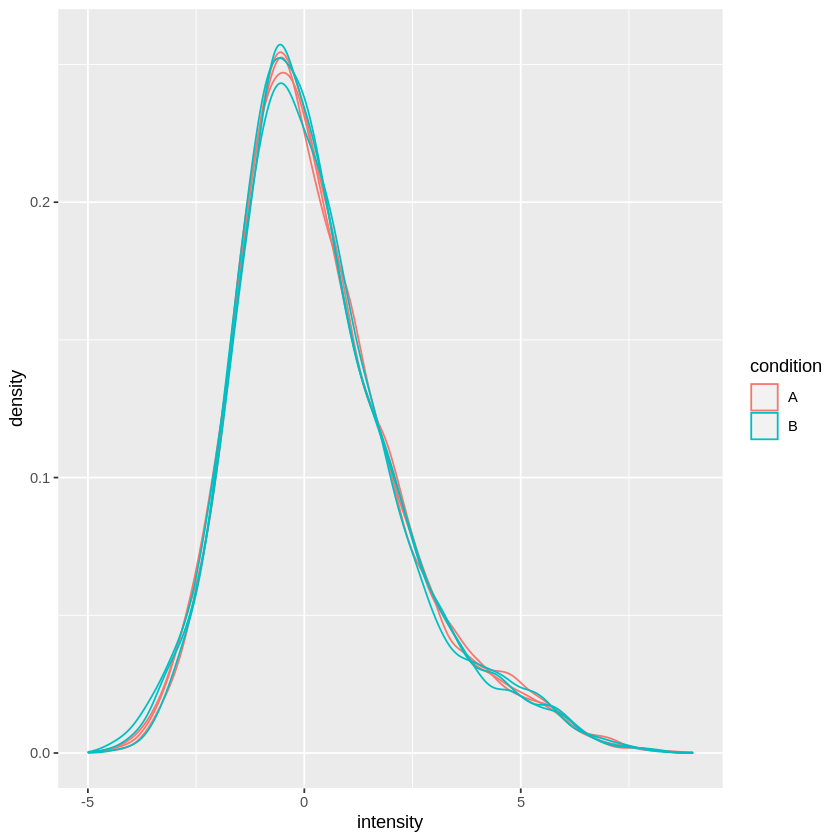

In [99]:
pe[['peptideNorm']] %>%
  assay %>%
  as.data.frame %>%
  gather(sample, intensity) %>%
  mutate(condition = colData(pe)[sample, 'condition']) %>%
  ggplot(aes(x = intensity, group = sample, color = condition)) +
  geom_density()

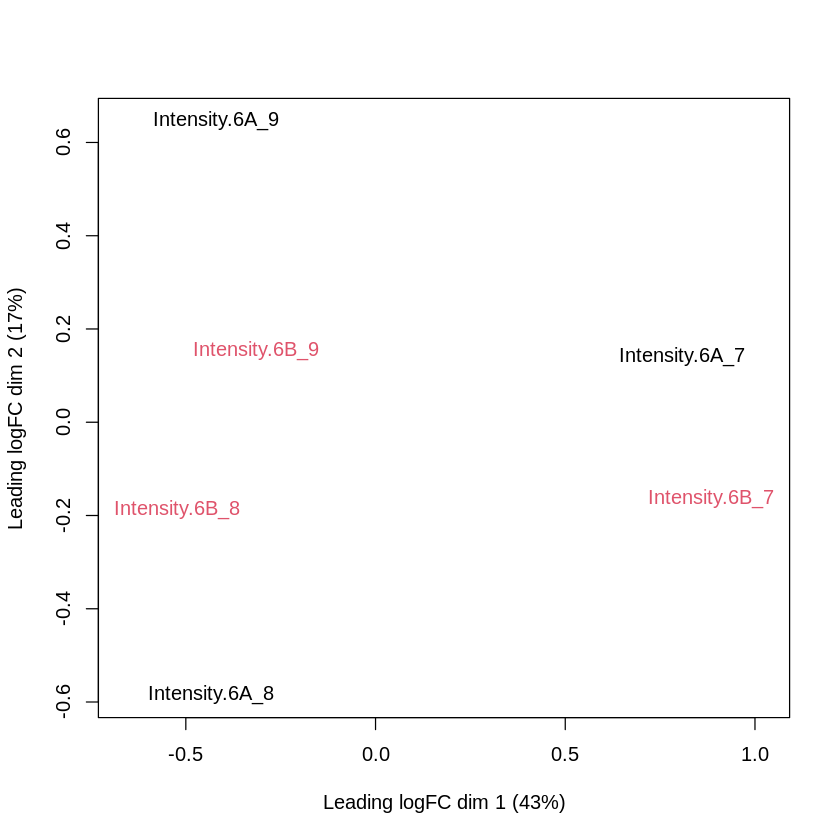

In [100]:
pe[['peptideNorm']] %>%
  assay %>%
  limma::plotMDS(col = as.numeric(colData(pe)$condition))

Note that leading differences (logFC) in the peptide data seems to be driven by technical variability. Indeed, the samples do not seem to be clearly separated according to the spike-in condition

In [101]:
# Summarization to protein level
pe <- aggregateFeatures(pe,
  i = 'peptideNorm',
  fcol = 'Proteins',
  na.rm = TRUE,
  name = 'protein')

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.



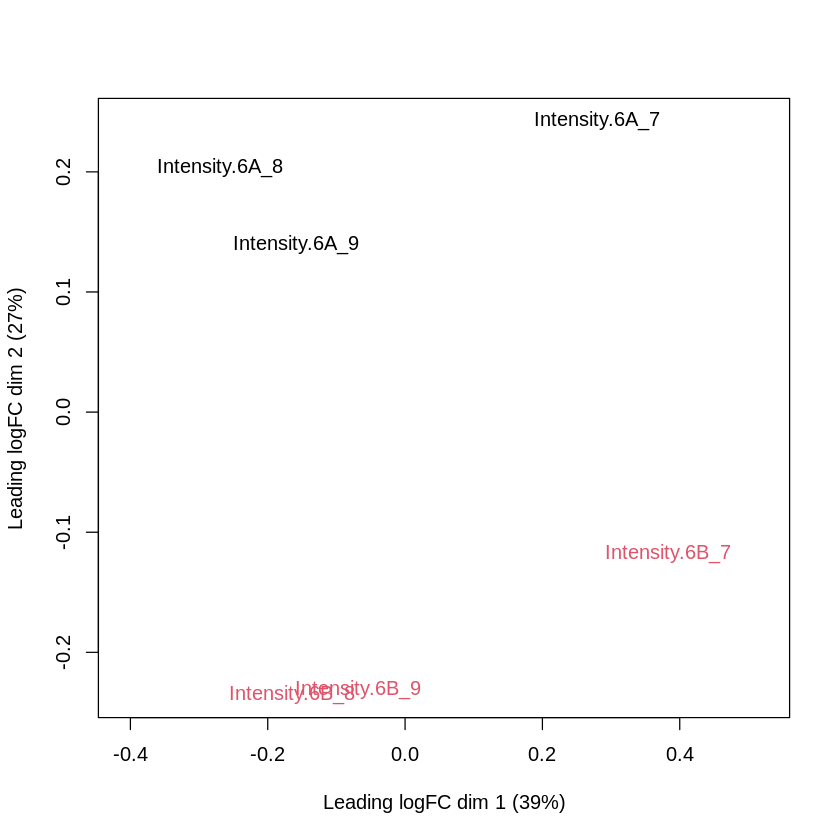

In [102]:
plotMDS(assay(pe[['protein']]), col = as.numeric(colData(pe)$condition))

samples upon robust summarisation show a clear separation according to the spike-in condition in the 2nd dimension of the MDS plot

In [106]:
# Data analysis
# model the data w/ a diff group mean, model the protein level expression values
pe <- msqrob(object = pe, i = 'protein', formula = ~condition)

# inference
getCoef(rowData(pe[['protein']])$msqrobModels[[1]])

(Intercept)  conditionB 
  -2.672396    1.513682

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.13 (BiocManager 1.30.16), R 4.1.0 (2021-05-18)

Installing package(s) 'ExploreModelMatrix'

also installing the dependencies ‘sass’, ‘jquerylib’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘bslib’, ‘shiny’, ‘shinydashboard’, ‘DT’, ‘cowplot’, ‘rintrojs’, ‘shinyjs’


Old packages: 'blob', 'broom', 'cli', 'credentials', 'googledrive',
  'googlesheets4', 'haven', 'openssl', 'pillar', 'readr', 'reprex',
  'rmarkdown', 'rvest', 'stringi', 'tibble', 'tinytex', 'utf8', 'xfun'



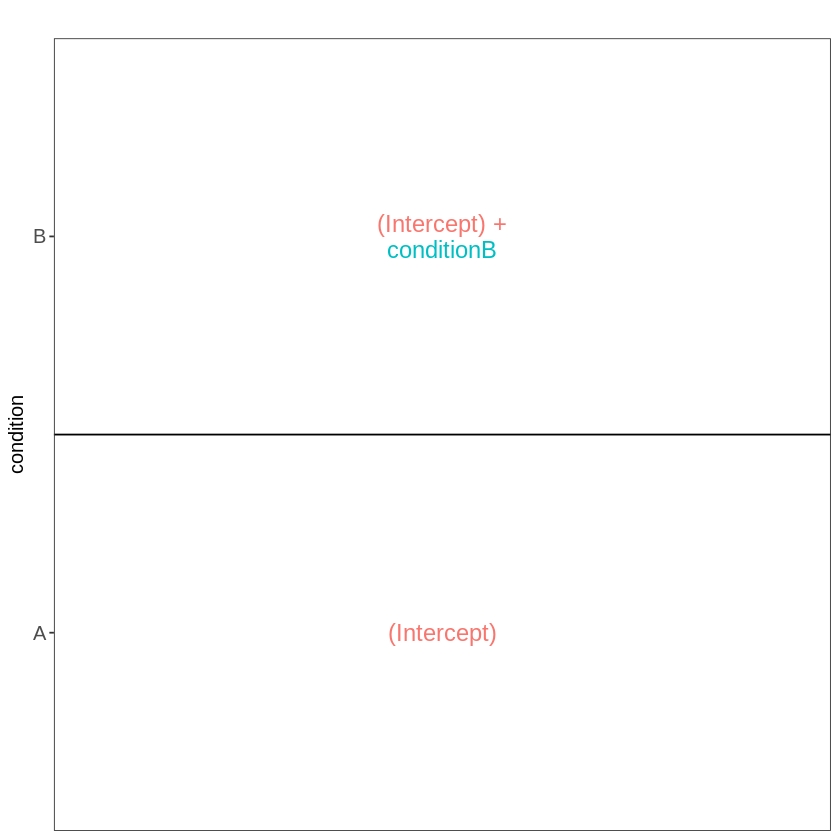

In [108]:
BiocManager::install("ExploreModelMatrix")

library(ExploreModelMatrix)
VisualizeDesign(colData(pe),~condition)$plotlist[[1]]

Spike-in condition A is the reference class. So the mean log2 expression for samples from condition A is ‘(Intercept). The mean log2 expression for samples from condition B is’(Intercept)+conditionB’. Hence, the average log2 fold change between condition b and condition a is modelled using the parameter ‘conditionB’. Thus, we assess the contrast ‘conditionB = 0’ with our statistical test.

In [109]:
L <- makeContrast('conditionB=0', parameterNames = c('conditionB'))
pe <- hypothesisTest(object = pe, i = 'protein', contrast = L)

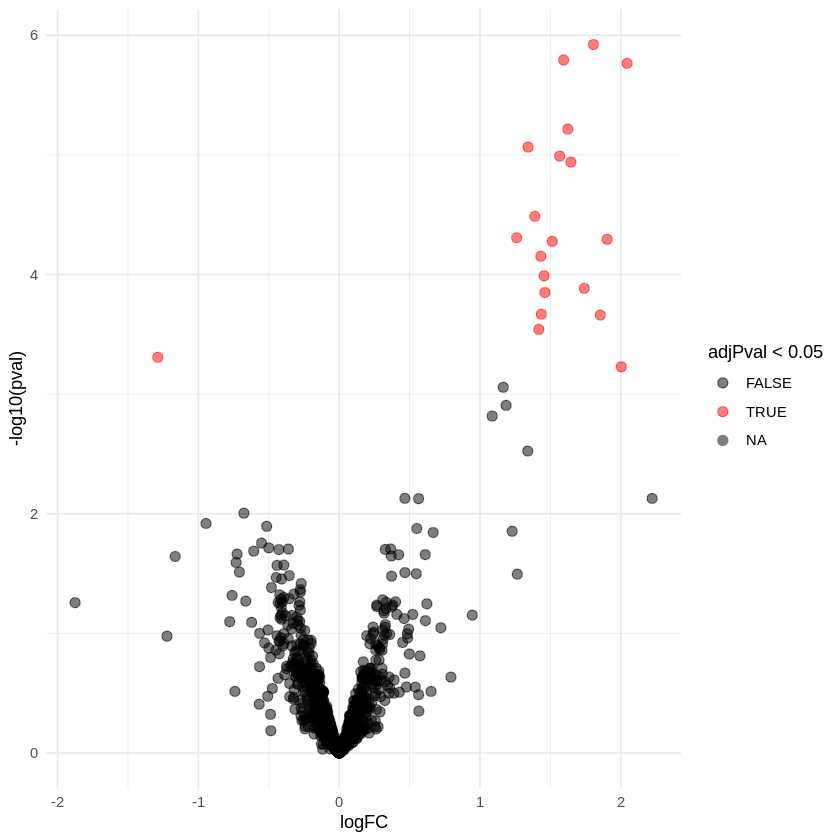

In [113]:
ggplot(rowData(pe[['protein']])$conditionB,
          aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)) +
        geom_point(cex = 2.5) + 
        scale_color_manual(values = alpha(c('black', 'red'), 0.5)) + theme_minimal()

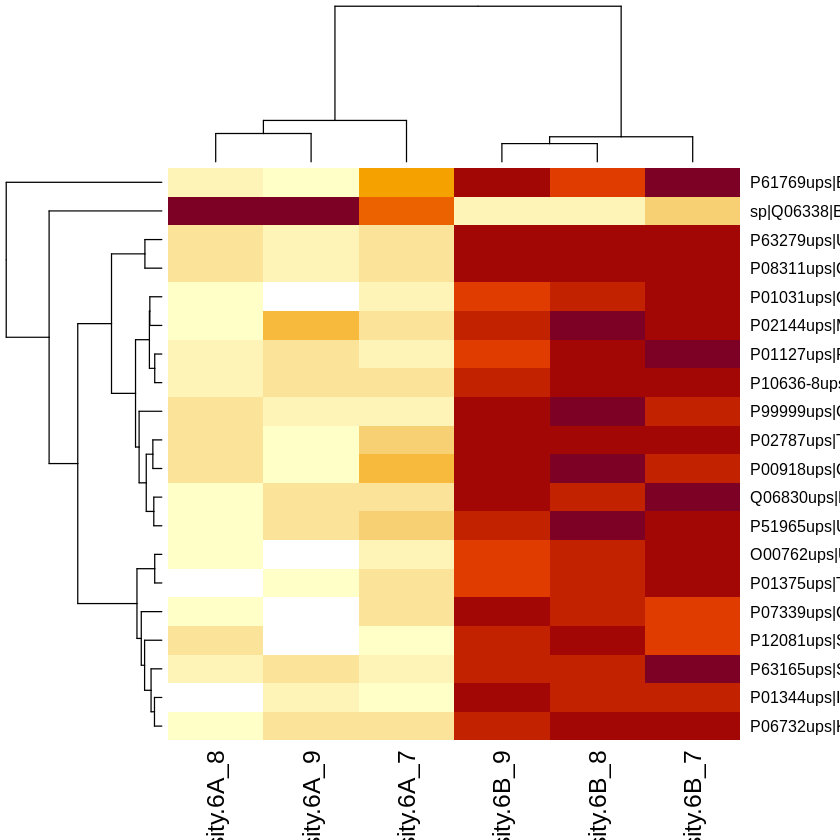

In [114]:
# there are 20 differentially abundant proteins
sigNames <- rowData(pe[['protein']])$conditionB %>%
  rownames_to_column('protein') %>%
  filter(adjPval < 0.05) %>%
  pull(protein)
heatmap(assay(pe[['protein']])[sigNames,])

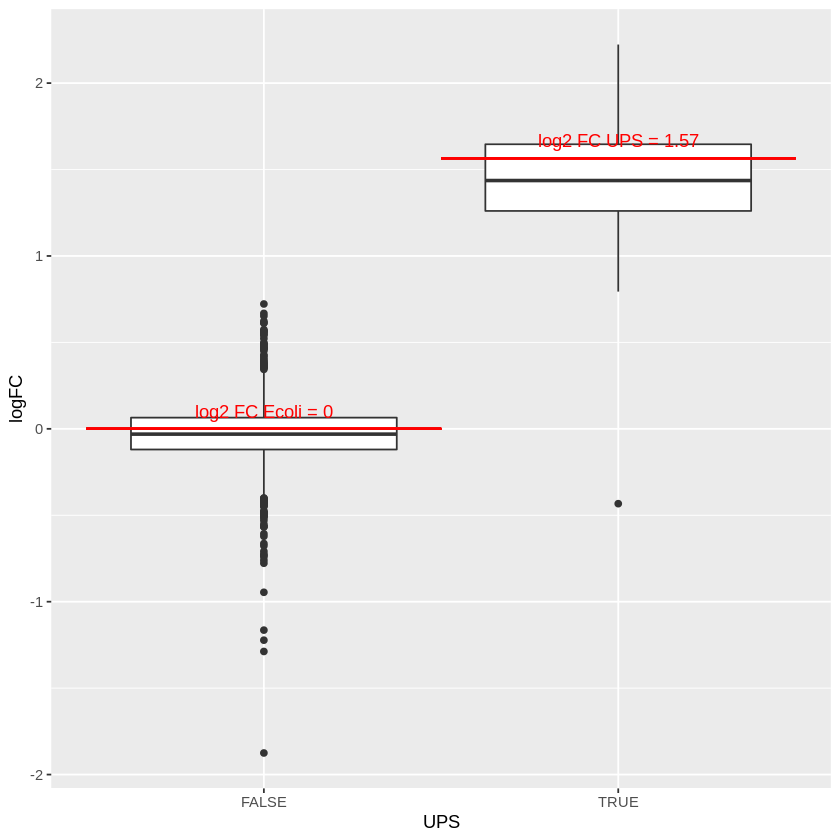

In [115]:
# make boxplots of the log2FC and stratify according to whether a protein is spiked or not
rowData(pe[['protein']])$conditionB %>%
  rownames_to_column(var = 'protein') %>%
  ggplot(aes(x = grepl('UPS', protein) , y=logFC)) +
  geom_boxplot() + 
  xlab('UPS') +
  geom_segment(
    x = 1.5, xend = 2.5,
    y = log2(0.74/0.25), yend = log2(0.74/0.25), colour = 'red') +
  geom_segment(
    x = 0.5, xend = 1.5,
    y = 0, yend = 0, colour = 'red') +
  annotate(
    'text',
    x = c(1, 2),
    y = c(0, log2(0.74/0.25)) + .1,
    label = c(
      'log2 FC Ecoli = 0',
      paste0('log2 FC UPS = ', round(log2(0.74/0.25), 2))
    ),
    colour = 'red'
  )

In [ ]:
for (protName in sigNames)
{
pePlot <- pe[protName, , c("peptideNorm","protein")]
pePlotDf <- data.frame(longFormat(pePlot))
pePlotDf$assay <- factor(pePlotDf$assay,
                        levels = c("peptideNorm", "protein"))
pePlotDf$condition <- as.factor(colData(pePlot)[pePlotDf$colname, "condition"])

# plotting
p1 <- ggplot(data = pePlotDf,
       aes(x = colname, y = value, group = rowname)) +
    geom_line() + 
    geom_point() +  
    theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 0.5)) +
    facet_grid(~assay) + 
    ggtitle(protName)
print(p1)

# plotting 2
p2 <- ggplot(pePlotDf, aes(x = colname, y = value, fill = condition)) +
  geom_boxplot(outlier.shape = NA) + 
  geom_point(
    position = position_jitter(width = .1),
    aes(shape = rowname)) +
  scale_shape_manual(values = 1:nrow(pePlotDf)) +
  labs(title = protName, x = "sample", y = "peptide intensity (log2)") + 
  theme(axis.text.x = element_text(angle = 70, hjust = 1, vjust = 0.5)) +
  facet_grid(~assay)
print(p2)
}

Note, that the yeast protein is only covered by 3 peptides. Only one peptide is picked up in condition A. This peptide is also only once observed in spike-in condition B. This puts a considerable burden upon the inference and could be avoided by more stringent filtering.



## Wrap-up 

Peptide-level models for summarization and inference

1. Subset of CPTAC study: A vs B comparison in lab 3

In [138]:
proteinsFile <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/cptacAvsB_lab3/proteinGroups.txt"

ecols <- grep("LFQ\\.intensity\\.", names(read.delim(proteinsFile)))

peLFQ <- readQFeatures(
  table = proteinsFile, fnames = 1, ecol = ecols,
  name = "proteinRaw", sep = "\t"
)

cond <- which(
  strsplit(colnames(peLFQ)[[1]][1], split = "")[[1]] == "A") # find where condition is stored

colData(peLFQ)$condition <- substr(colnames(peLFQ), cond, cond) %>%
  unlist %>%  
  as.factor

In [139]:
# preprocessing
rowData(peLFQ[["proteinRaw"]])$nNonZero <- rowSums(assay(peLFQ[["proteinRaw"]]) > 0)

peLFQ <- zeroIsNA(peLFQ, "proteinRaw") # convert 0 to NA

peLFQ <- logTransform(peLFQ, base = 2, i = "proteinRaw", name = "proteinLog")

peLFQ[["proteinLog"]] <- peLFQ[["proteinLog"]][rowData(peLFQ[["proteinLog"]])$Reverse != "+", ]
peLFQ[["proteinLog"]] <- peLFQ[["proteinLog"]][rowData(peLFQ[["proteinLog"]])$
                                           Potential.contaminant != "+", ]
peLFQ <- normalize(peLFQ, 
                i = "proteinLog", 
                name = "protein", 
                method = "center.median")

In [140]:
# modeling and inference
peLFQ <- msqrob(object = peLFQ, i = 'protein', formula = ~condition)

In [141]:
L <- makeContrast("conditionB=0", parameterNames = c("conditionB"))
peLFQ <- hypothesisTest(object = peLFQ, i = 'protein', contrast = L)

volcanoLFQ <- ggplot(rowData(peLFQ[["protein"]])$conditionB,
                  aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)) +
  geom_point(cex = 2.5) +
  scale_color_manual(values = alpha(c("black", "red"), 0.5)) + 
  theme_minimal() +
  ggtitle(paste0("maxLFQ: TP = ",sum(rowData(peLFQ[["protein"]])$conditionB$adjPval<0.05&grepl(rownames(rowData(peLFQ[["protein"]])$conditionB),pattern ="UPS"),na.rm=TRUE),
   " FP = ", sum(rowData(peLFQ[["protein"]])$conditionB$adjPval<0.05&!grepl(rownames(rowData(peLFQ[["protein"]])$conditionB),pattern ="UPS"),na.rm=TRUE)))

In [131]:
# median and robust summarization
peptidesFile <- "https://raw.githubusercontent.com/statOmics/SGA2020/data/quantification/cptacAvsB_lab3/peptides.txt"

ecols <- grep(
  "Intensity\\.", 
  names(read.delim(peptidesFile))
  )

pe <- readQFeatures(
  table = peptidesFile,
  fnames = 1,
  ecol = ecols,
  name = "peptideRaw", sep="\t")

cond <- which(
  strsplit(colnames(pe)[[1]][1], split = "")[[1]] == "A") # find where condition is stored

colData(pe)$condition <- substr(colnames(pe), cond, cond) %>%
  unlist %>%  
  as.factor

# preprocessing
rowData(pe[["peptideRaw"]])$nNonZero <- rowSums(assay(pe[["peptideRaw"]]) > 0)

pe <- zeroIsNA(pe, "peptideRaw") # convert 0 to NA

pe <- logTransform(pe, base = 2, i = "peptideRaw", name = "peptideLog")

pe[["peptideLog"]] <-
 pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Proteins
 %in% smallestUniqueGroups(rowData(pe[["peptideLog"]])$Proteins),]

pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Reverse != "+", ]
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$
    Potential.contaminant != "+", ]

pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$nNonZero >= 2, ]
nrow(pe[["peptideLog"]])

[1] 7011

In [132]:
pe <- normalize(pe, 
                i = "peptideLog", 
                name = "peptideNorm", 
                method = "center.median")

pe <- aggregateFeatures(pe,
  i = "peptideNorm",
  fcol = "Proteins",
  na.rm = TRUE,
  name = "proteinMedian",
  fun = matrixStats::colMedians)

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.



In [133]:
pe <- aggregateFeatures(pe,
  i = 'peptideNorm', 
  fcol = 'Proteins',
  na.rm = TRUE,
  name = 'proteinRobust')

Your quantitative and row data contain missing values. Please read the
relevant section(s) in the aggregateFeatures manual page regarding the
effects of missing values on data aggregation.



In [134]:
pe <- msqrob(object = pe, i = "proteinMedian", formula = ~condition)

L <- makeContrast("conditionB=0", parameterNames = c("conditionB"))
pe <- hypothesisTest(object = pe, i = "proteinMedian", contrast = L)

pe <- msqrob(object = pe, i = "proteinRobust", formula = ~condition)
pe <- hypothesisTest(object = pe, i = "proteinRobust", contrast = L)

In [135]:
volcanoMedian <- ggplot(rowData(pe[["proteinMedian"]])$conditionB,
                  aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)) +
  geom_point(cex = 2.5) +
  scale_color_manual(values = alpha(c("black", "red"), 0.5)) + 
  theme_minimal() +
  ggtitle(paste0("Median: TP = ",sum(rowData(pe[["proteinMedian"]])$conditionB$adjPval<0.05&grepl(rownames(rowData(pe[["proteinMedian"]])$conditionB),pattern ="UPS"),na.rm=TRUE), 
  " FP = ", sum(rowData(pe[["proteinMedian"]])$conditionB$adjPval<0.05&!grepl(rownames(rowData(pe[["proteinMedian"]])$conditionB),pattern ="UPS"),na.rm=TRUE)))

volcanoRobust<- ggplot(rowData(pe[["proteinRobust"]])$conditionB,
                  aes(x = logFC, y = -log10(pval), color = adjPval < 0.05)) +
  geom_point(cex = 2.5) +
  scale_color_manual(values = alpha(c("black", "red"), 0.5)) + 
  theme_minimal() +
  ggtitle(paste0("Robust: TP = ",sum(rowData(pe[["proteinRobust"]])$conditionB$adjPval<0.05&grepl(rownames(rowData(pe[["proteinRobust"]])$conditionB),pattern ="UPS"),na.rm=TRUE), 
  " FP = ", sum(rowData(pe[["proteinRobust"]])$conditionB$adjPval<0.05&!grepl(rownames(rowData(pe[["proteinRobust"]])$conditionB),pattern ="UPS"),na.rm=TRUE)))

In [142]:
ylims <- c(0, 
           ceiling(max(c(-log10(rowData(peLFQ[["protein"]])$conditionB$pval),
               -log10(rowData(pe[["proteinMedian"]])$conditionB$pval),
               -log10(rowData(pe[["proteinRobust"]])$conditionB$pval)),
               na.rm=TRUE))
)

xlims <- max(abs(c(rowData(peLFQ[["protein"]])$conditionB$logFC,
               rowData(pe[["proteinMedian"]])$conditionB$logFC,
               rowData(pe[["proteinRobust"]])$conditionB$logFC)),
               na.rm=TRUE) * c(-1,1)

In [144]:
compBoxPlot <- rbind(rowData(peLFQ[["protein"]])$conditionB %>% mutate(method="maxLFQ") %>% rownames_to_column(var="protein"),
      rowData(pe[["proteinMedian"]])$conditionB %>% mutate(method="median")%>% rownames_to_column(var="protein"),
      rowData(pe[["proteinRobust"]])$conditionB%>% mutate(method="robust")%>% rownames_to_column(var="protein")) %>%
      mutate(ups= grepl(protein,pattern="UPS")) %>%
    ggplot(aes(x = method, y = logFC, fill = ups)) +
    geom_boxplot() +
    geom_hline(yintercept = log2(0.74 / .25), color = "#00BFC4") +
    geom_hline(yintercept = 0, color = "#F8766D")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


The following object is masked from ‘package:dplyr’:

    combine




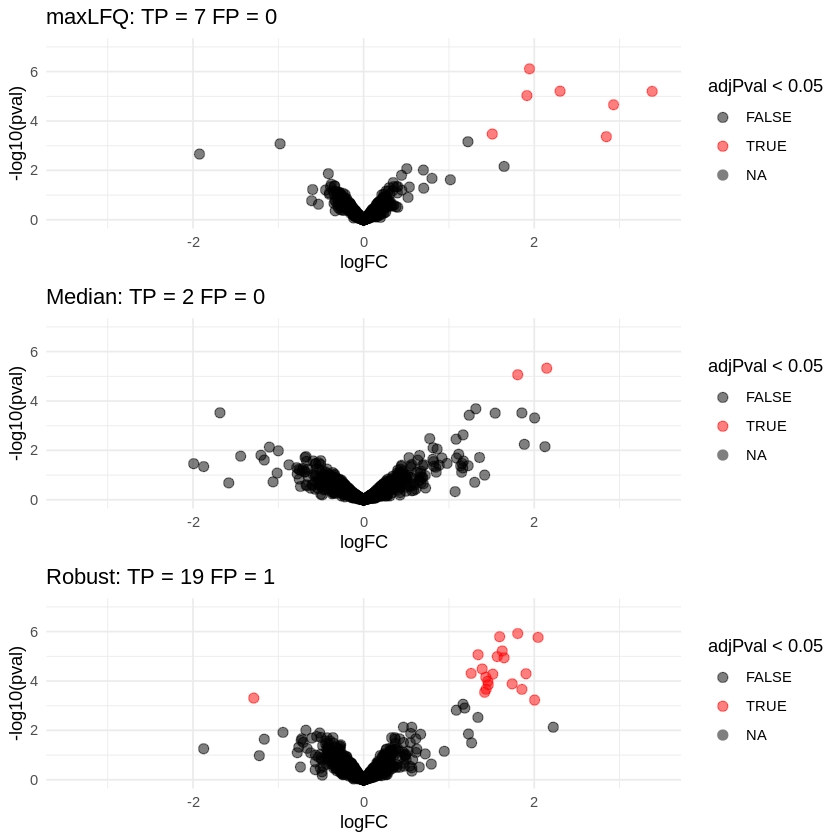

In [147]:
install.packages('gridExtra')
library(gridExtra)
grid.arrange(volcanoLFQ + xlim(xlims) + ylim(ylims), 
             volcanoMedian + xlim(xlims) + ylim(ylims), 
             volcanoRobust + xlim(xlims) + ylim(ylims),
             ncol=1)

Robust summarization: highest power and still good FDR control:

$FDP = \frac{1}{20} = 0.05$

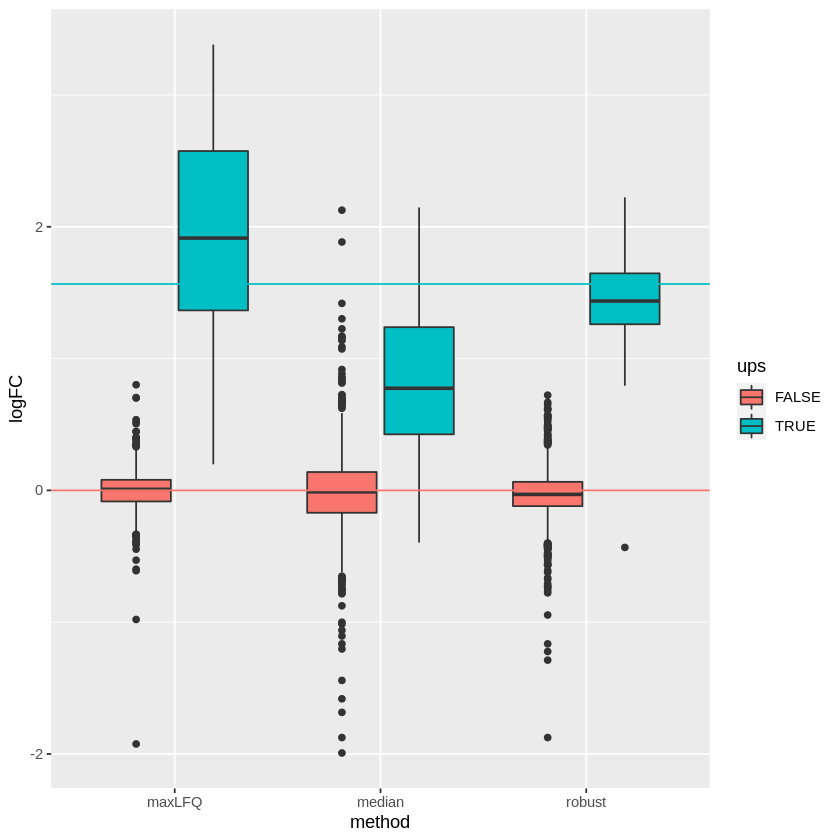

In [148]:
compBoxPlot

- Median: biased logFC estimates for spike-in proteins

- maxLFQ: more variable logFC estimates for spike-in proteins

2. Full CPTAC Study

In [159]:
peptidesFile <- "https://raw.githubusercontent.com/statOmics/PDA21/data/quantification/fullCptacDatasSetNotForTutorial/peptides.txt"
ecols <- grep("Intensity\\.", names(read.delim(peptidesFile)))
pe <- readQFeatures(
  table = peptidesFile,
  fnames = 1,
  ecol = ecols,
  name = "peptideRaw", sep="\t")


In [160]:
pe %>% colnames

CharacterList of length 1
[["peptideRaw"]] Intensity.6A_1 Intensity.6A_2 ... Intensity.6E_9

In [161]:
colData(pe)$lab <- rep(rep(paste0("lab",1:3),each=3),5) %>% as.factor
colData(pe)$condition <- pe[["peptideRaw"]] %>% colnames %>% substr(12,12) %>% as.factor
colData(pe)$spikeConcentration <- rep(c(A = 0.25, B = 0.74, C = 2.22, D = 6.67, E = 20),each = 9)

colData(pe)

DataFrame with 45 rows and 3 columns
                    lab condition spikeConcentration
               <factor>  <factor>          <numeric>
Intensity.6A_1     lab1         A               0.25
Intensity.6A_2     lab1         A               0.25
Intensity.6A_3     lab1         A               0.25
Intensity.6A_4     lab2         A               0.25
Intensity.6A_5     lab2         A               0.25
...                 ...       ...                ...
Intensity.6E_5     lab2         E                 20
Intensity.6E_6     lab2         E                 20
Intensity.6E_7     lab3         E                 20
Intensity.6E_8     lab3         E                 20
Intensity.6E_9     lab3         E                 20

In [162]:
# preprocessing
# log-transform

# non-zero intensities for each peptide
rowData(pe[["peptideRaw"]])$nNonZero <- rowSums(assay(pe[["peptideRaw"]]) > 0)

# NA instead of 0
pe <- zeroIsNA(pe, 'peptideRaw') 

pe <- logTransform(pe, base = 2, i = 'peptideRaw', name = 'peptideLog')

In [163]:
# filtering

# 1. overlapping protein groups
pe[["peptideLog"]] <-
 pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Proteins
 %in% smallestUniqueGroups(rowData(pe[["peptideLog"]])$Proteins),]

# 2. remove reverse sequences and contaminants
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$Reverse != "+", ]
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$
    Potential.contaminant != "+", ]

# 3. drop peptides identified only in 1 sample
pe[["peptideLog"]] <- pe[["peptideLog"]][rowData(pe[["peptideLog"]])$nNonZero >= 2, ]
nrow(pe[["peptideLog"]])

[1] 10478

In [164]:
# normalization
pe <- normalize(pe, 
                i = "peptideLog", 
                name = "peptideNorm", 
                method = "center.median")

In [171]:
# summarization
prot <- "P01031ups|CO5_HUMAN_UPS"
data <- pe[["peptideNorm"]][
  rowData(pe[["peptideNorm"]])$Proteins == prot,
  colData(pe)$lab=="lab3"] %>%
  assay %>%
  as.data.frame %>%
  rownames_to_column(var = "peptide") %>%
  gather(sample, intensity, -peptide) %>% 
  mutate(condition = colData(pe)[sample,"condition"]) %>%
  na.exclude
sumPlot <- data %>%
  ggplot(aes(x = peptide, y = intensity, color = condition, group = sample, label = condition), show.legend = FALSE) +
  geom_text(show.legend = FALSE) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  xlab("Peptide") + 
  ylab("Intensity (log2)") +
  ggtitle(paste0("protein: ",prot))

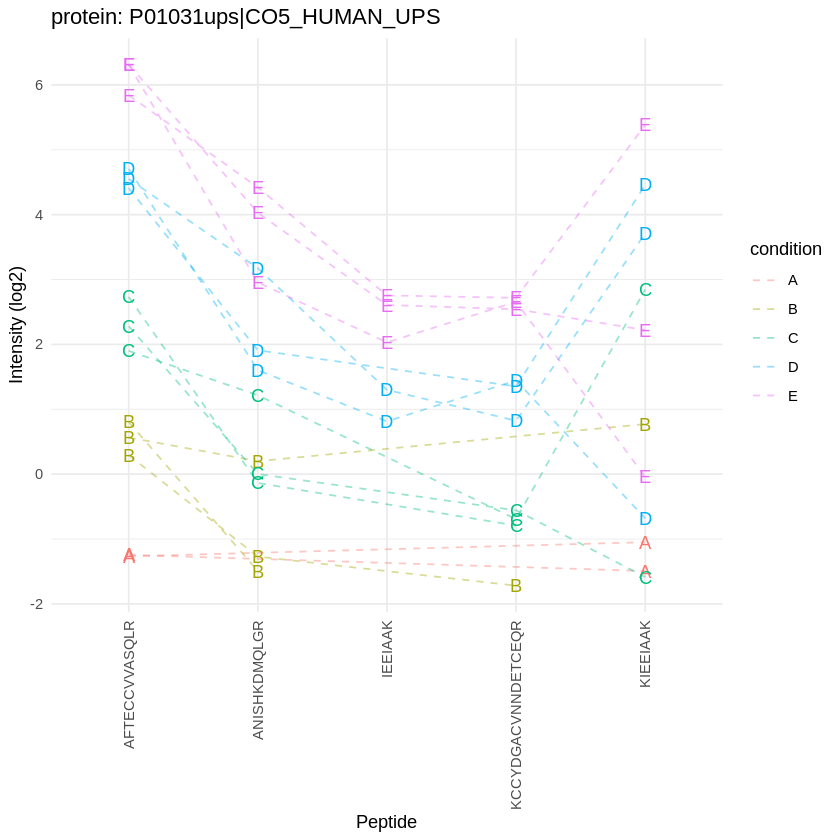

In [172]:
sumPlot +
  geom_line(linetype='dashed', alpha=.4)

In [173]:
# Median normalization
dataHlp <- pe[["peptideNorm"]][
    rowData(pe[["peptideNorm"]])$Proteins == prot,
    colData(pe)$lab=="lab3"] %>% assay 

sumMedian <- data.frame(
  intensity= dataHlp
    %>% colMedians(na.rm=TRUE)
  ,
  condition= colnames(dataHlp) %>% substr(12,12) %>% as.factor )

sumMedianPlot <- sumPlot + 
  geom_hline(
    data = sumMedian,
    mapping = aes(yintercept=intensity,color=condition)) + 
  ggtitle("Median summarization")

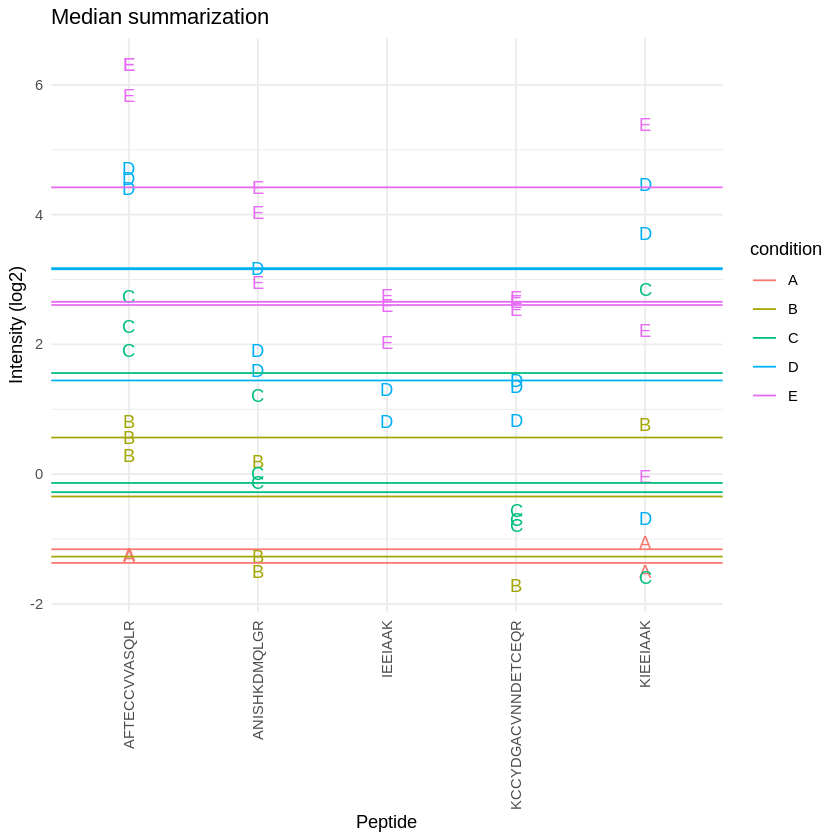

In [174]:
sumMedianPlot

- the sample medians aren't a good estimate for the protein expression value

- indeed, they don't account for differences in peptide effects

- peptides that ionize poorly are also picked up in samples w/ high spike-in concentration and not in samples w/ low spike-in concentration

- this introduces a bias

In [175]:
# Mean summarization
sumMeanMod <- lm(intensity ~ -1 + sample,data)

sumMean <- data.frame(
  intensity=sumMeanMod$coef[grep("sample",names(sumMeanMod$coef))],
  condition= names(sumMeanMod$coef)[grep("sample",names(sumMeanMod$coef))] %>% substr(18,18) %>% as.factor )


sumMeanPlot <- sumPlot + geom_hline(
    data = sumMean,
    mapping = aes(yintercept=intensity,color=condition)) +
    ggtitle("Mean summarization")

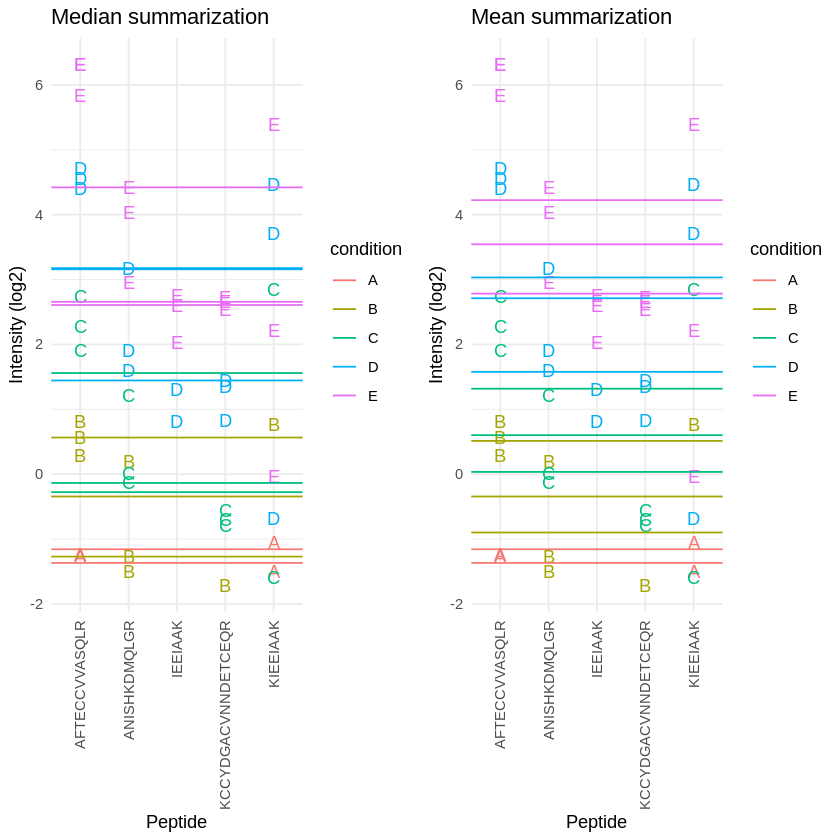

In [176]:
grid.arrange(sumMedianPlot, sumMeanPlot, ncol=2)

In [177]:
# Model based summarization
sumMeanPepMod <- lm(intensity ~ -1 + sample + peptide,data)

sumMeanPep <- data.frame(
  intensity=sumMeanPepMod$coef[grep("sample",names(sumMeanPepMod$coef))] + mean(data$intensity) - mean(sumMeanPepMod$coef[grep("sample",names(sumMeanPepMod$coef))]),
  condition= names(sumMeanPepMod$coef)[grep("sample",names(sumMeanPepMod$coef))] %>% substr(18,18) %>% as.factor )


fitLmPlot <-  sumPlot + geom_line(
    data = data %>% mutate(fit=sumMeanPepMod$fitted.values),
    mapping = aes(x=peptide, y=fit,color=condition, group=sample)) +
    ggtitle("fit: ~ sample + peptide")
sumLmPlot <- sumPlot + geom_hline(
    data = sumMeanPep,
    mapping = aes(yintercept=intensity,color=condition)) +
    ggtitle("Summarization: sample effect")

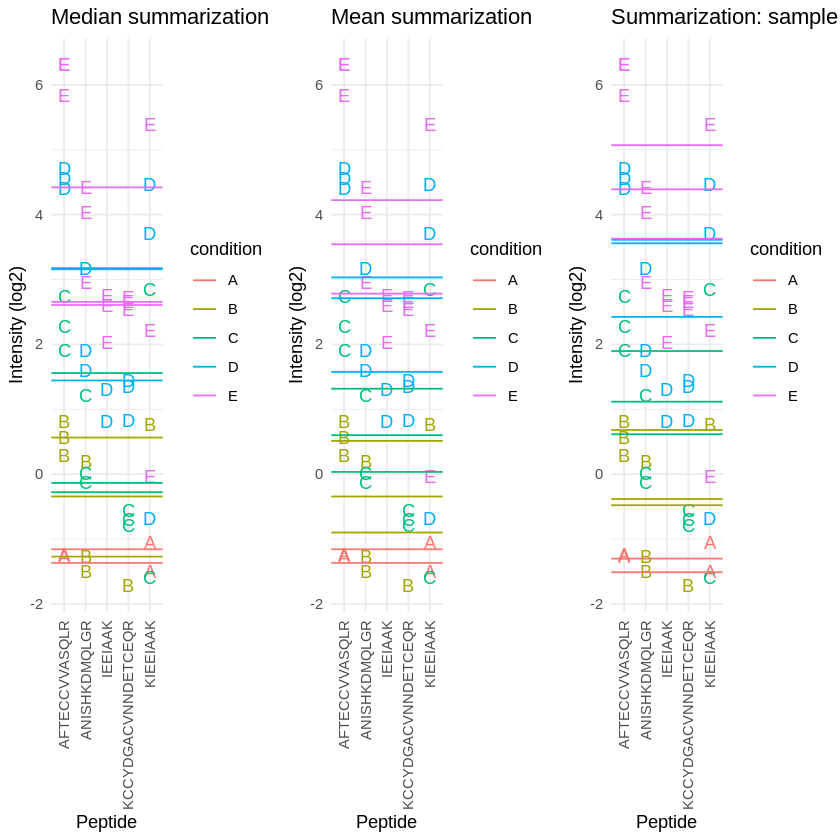

In [178]:
grid.arrange(sumMedianPlot, sumMeanPlot, sumLmPlot, nrow = 1)

- by correcting for the peptide species in the protein expression values are much better separated and better reflect differences in abundance induced by the spike-in condition 

- indeed, it shows that median and mean summarization that do not account for the peptide effect indeed overestimate the protein expresison value in the small spike-in conditions and underestimate that in the large spike-in conditions

- still there seem to be some issues w/ samples that for which the expression values aren't well separated according to the spike-in condition

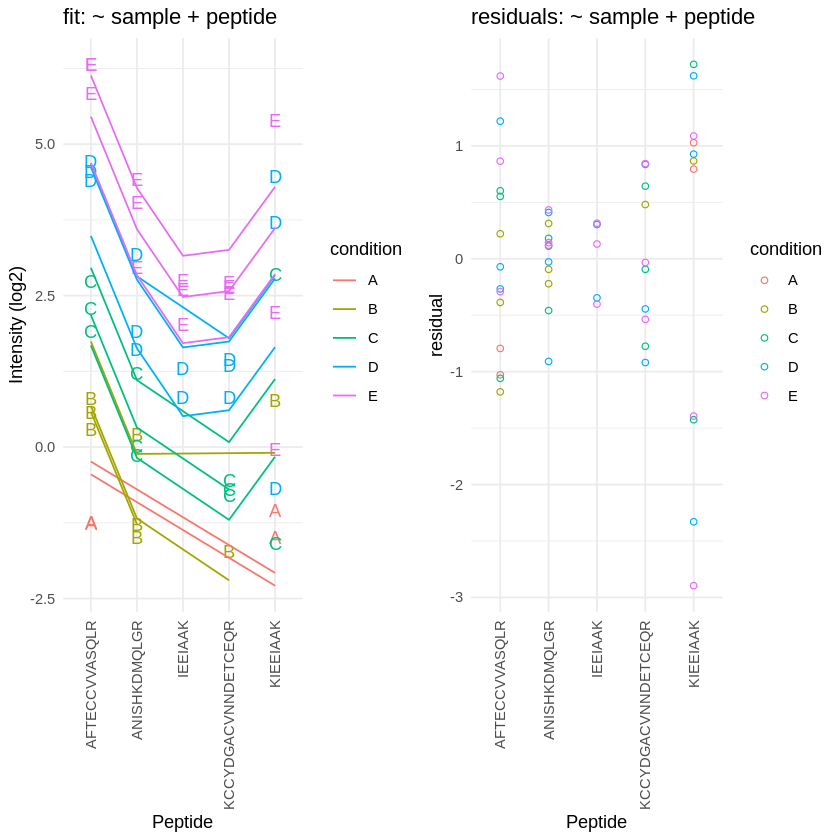

In [179]:
resPlot <- data %>% 
  mutate(res=sumMeanPepMod$residuals) %>%
  ggplot(aes(x = peptide, y = res, color = condition, label = condition), show.legend = FALSE) +
  geom_point(shape=21) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  xlab("Peptide") + 
  ylab("residual") +
  ggtitle("residuals: ~ sample + peptide")

grid.arrange(fitLmPlot, resPlot, nrow = 1)

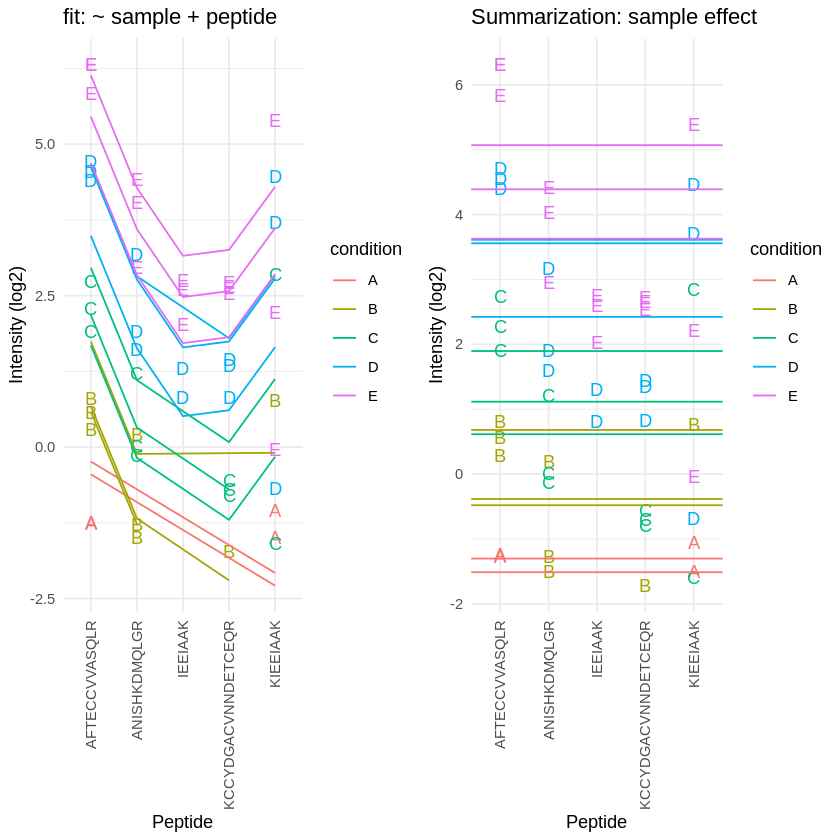

In [180]:
grid.arrange(fitLmPlot, sumLmPlot, nrow = 1)

- the residual plot shows some large outliers for peptide KIEEIAAK

- indeed, in the original plot the intensities for this peptide do not seem to line up very well w/ the concentration

- this induces a bias in the summarization for some of the samples (e.g. for D and E)

Robust summarization using a peptide-level linear model

Replace OLS 

$OLS: \sum_{i, p}\epsilon_{ip}^2 = \sum_{i, p} (y_{ip} - \beta_i^{sample} - \beta_p^{peptide})^2$ 

by M-estimation w/ loss function
$\sum_{i, p}w_{ip} \epsilon_{ip}^2 = \sum_{i, p} w_{ip} (y_{ip} - \beta_i^{sample} - \beta_p^{peptide})^2$ 

- iteratively fit model w/ observation weights $w_{ip}$ until convergence

- the weights are calculated based on standardized residuals


In [182]:
sumMeanPepRobMod <- MASS::rlm(intensity ~ -1 + sample + peptide,data)
resRobPlot <- data %>%
  mutate(res = sumMeanPepRobMod$residuals,
         w = sumMeanPepRobMod$w) %>%
  ggplot(aes(x = peptide, y = res, color = condition, label = condition,size=w), show.legend = FALSE) +
  geom_point(shape=21,size=.2) +
  geom_point(shape=21) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  xlab("Peptide") + 
  ylab("residual") + 
  ylim(c(-1,1)*max(abs(sumMeanPepRobMod$residuals)))
weightPlot <- qplot(
  seq(-5,5,.01), 
  MASS::psi.huber(seq(-5,5,.01)),
  geom="path") +
  xlab("standardized residual") +
  ylab("weight")

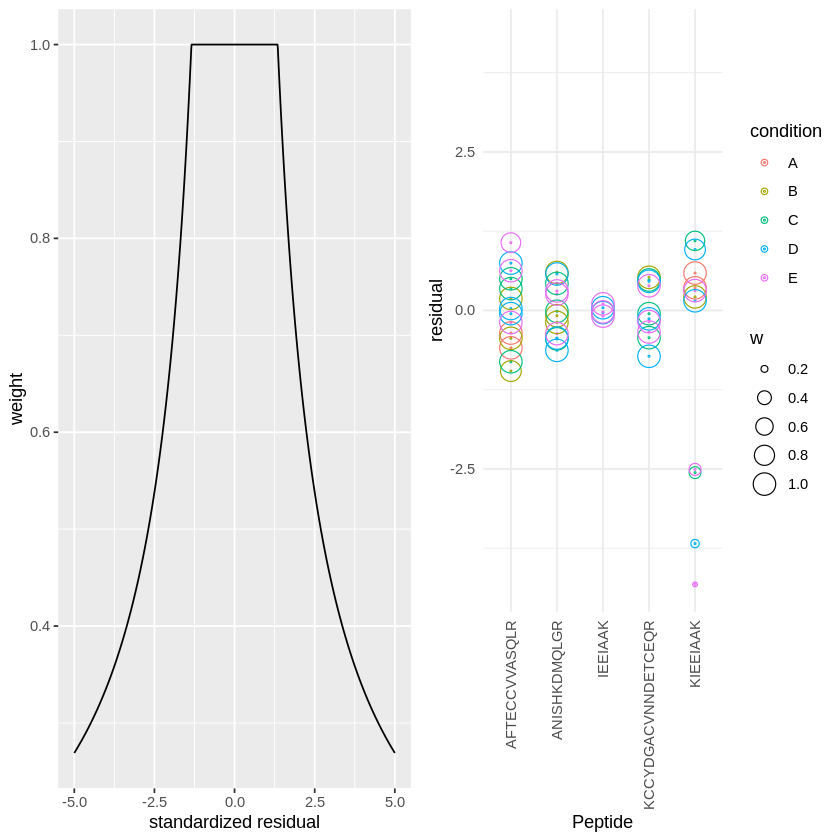

In [183]:
grid.arrange(weightPlot, resRobPlot, nrow=1)

the weights in the M-estimation procedure will down-weight errors associated w/ outliers for peptide KIEEIAAK

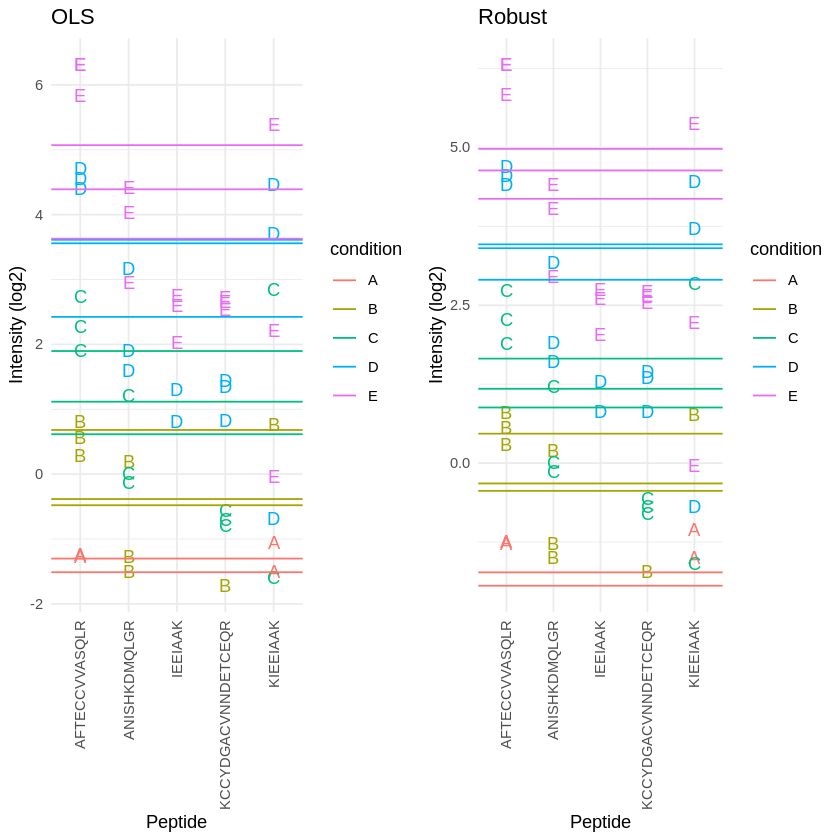

In [184]:
sumMeanPepRob <- data.frame(
  intensity=sumMeanPepRobMod$coef[grep("sample",names(sumMeanPepRobMod$coef))] + mean(data$intensity) - mean(sumMeanPepRobMod$coef[grep("sample",names(sumMeanPepRobMod$coef))]),
  condition= names(sumMeanPepRobMod$coef)[grep("sample",names(sumMeanPepRobMod$coef))] %>% substr(18,18) %>% as.factor )

sumRlmPlot <- sumPlot + geom_hline(
    data=sumMeanPepRob,
    mapping=aes(yintercept=intensity,color=condition)) + 
    ggtitle("Robust")

 grid.arrange(sumLmPlot + ggtitle("OLS"), sumRlmPlot, nrow = 1)
